In [1]:
from pylab import *
from sklearn import cross_validation, tree
from toolbox_02450 import feature_selector_lr, bmplot
import sklearn.linear_model as lm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import neurolab as nl
import numpy as np


#print plots inline
%matplotlib inline

#Define names
names = ['word_freq_make', 'word_freq_address', 'word_freq_all',
         'word_freq_3d', 'word_freq_our', 'word_freq_over',
         'word_freq_remove', 'word_freq_internet', 'word_freq_order',
         'word_freq_mail', 'word_freq_receive', 'word_freq_will',
         'word_freq_people', 'word_freq_report', 'word_freq_addresses',
         'word_freq_free', 'word_freq_business', 'word_freq_email',
         'word_freq_you', 'word_freq_credit', 'word_freq_your',
         'word_freq_font', 'word_freq_000', 'word_freq_money',
         'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
         'word_freq_650', 'word_freq_lab', 'word_freq_labs',
         'word_freq_telnet', 'word_freq_857', 'word_freq_data',
         'word_freq_415', 'word_freq_85', 'word_freq_technology',
         'word_freq_1999', 'word_freq_parts', 'word_freq_pm',
         'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
         'word_freq_original', 'word_freq_project', 'word_freq_re',
         'word_freq_edu', 'word_freq_table', 'word_freq_conference',
         'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!',
         'char_freq_$', 'char_freq_#']
tst=['capital_run_length_average', 'capital_run_length_longest',
     'capital_run_length_total']

#clean up names
names=[s.replace('word_freq_','').replace('char_freq_','') for s in names]

#Load data
freq = pd.read_csv("../data/spambase.data",names=names,usecols=range(54))
Y = pd.read_csv("../data/spambase.data",usecols=[57],names=['spam'])

freq.head()

/usr/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,make,address,all,3d,our,over,remove,internet,order,mail,...,re,edu,table,conference,;,(,[,!,$,#
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000


In [2]:
#Get data and standardize
df = pd.read_csv("../data/spambase.data",names=names+tst,usecols=range(57))
Xd = (df - df.mean()) / (df.max() - df.min())
X = asmatrix(Xd)
y = Y.spam.values
X = np.asmatrix(X)
y = np.asmatrix(y).T


Crossvalidation fold: 1/5
The maximum number of train epochs is reached
Training error for hidden units 1, k-fold 0: 98.8848154740139...
Training error calculated: 0.05374174754022495
Test error calculated: 0.04996934574722438
The maximum number of train epochs is reached
Training error for hidden units 2, k-fold 0: 98.2089491372523...
Training error calculated: 0.05337442887894147
Test error calculated: 0.05071648054094864
The maximum number of train epochs is reached
Training error for hidden units 3, k-fold 0: 119.4517337653299...
Training error calculated: 0.06491942052463581
Test error calculated: 0.06577090475423751
The maximum number of train epochs is reached
Training error for hidden units 4, k-fold 0: 110.7313719295559...
Training error calculated: 0.06018009343997604
Test error calculated: 0.054803905644985274
The maximum number of train epochs is reached
Training error for hidden units 5, k-fold 0: 121.19553575318085...
Training error calculated: 0.06586713899629394
Test e

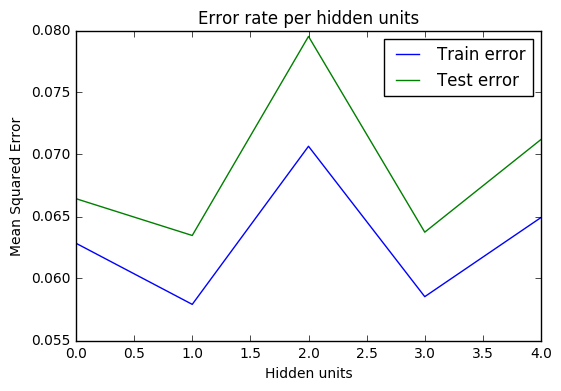

In [3]:
N, M = X.shape

# Parameters for neural network classifier
min_hidden_units = 1  # number of hidden units
n_hidden_units = 5  # number of hidden units
#n_train = 1  # number of networks trained in each k-fold
learning_goal = 0.5  # stop criterion 1 (train mse to be reached)
max_epochs = 32  # stop criterion 2 (max epochs in training)
show_error_freq = 200  # frequency of training status updates

# K-fold crossvalidation
K = 5 
CV = cross_validation.KFold(N, K, shuffle=True)

errors = np.zeros((n_hidden_units, K))
train_errors = np.zeros((n_hidden_units, K))
error_hist = np.zeros((max_epochs, K))
bestnet = list()
k = 0
for train_index, test_index in CV:
    print('\nCrossvalidation fold: {0}/{1}'.format(k + 1, K))

    # extract training and test set for current CV fold
    X_train = X[train_index, :]
    y_train = y[train_index, :]
    X_test = X[test_index, :]
    y_test = y[test_index, :]

    best_train_error = 1e100

    for hid in range(min_hidden_units, n_hidden_units+1):
        #print('Training network {0}/{1}...'.format(i + 1, n_train))
        # Create randomly initialized network with 2 layers
        ann = nl.net.newff([[-3, 3]] * M, [hid, 1], [nl.trans.TanSig(), nl.trans.PureLin()])
        bestnet.append(ann)

        # train network
        train_error = ann.train(X_train, y_train, goal=learning_goal, epochs=max_epochs, show=show_error_freq)
        # if train_error[-1] < best_train_error:
        #     bestnet[k] = ann
        #     best_train_error = train_error[-1]
        #     error_hist[range(len(train_error)), k] = train_error

        print('Training error for hidden units {0}, k-fold {1}: {2}...'.format(hid, k, train_error[-1]))
        y_est = ann.sim(X_test)
        errors[hid - 1][k] = np.square(y_est - y_test).sum().astype(float) / y_test.shape[0]

        train_est = ann.sim(X_train)
        train_errors[hid - 1][k] = np.square(train_est - y_train).sum().astype(float) / y_train.shape[0]
        print('Training error calculated: {0}'.format(train_errors[hid-1][k]))
        print('Test error calculated: {0}'.format(errors[hid - 1][k]))
    k += 1

# Print the average least squares error
print('Mean-square error: {0}'.format(mean(errors)))

figure()
plot(sum(train_errors,1) / K)
plot(sum(errors,1) / K)
legend(['Train error', 'Test error'])
xlabel('Hidden units')
ylabel('Mean Squared Error')
title('Error rate per hidden units')
savefig('img/ann_regression_hid_units.pdf')
show()